In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# WordCloud
from wordcloud import WordCloud

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# HuggingFace
import datasets

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)

# Progress report
from tqdm.notebook import tqdm

# Imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer
from keras.layers import (
        Dense,
        Flatten,
        InputLayer,
        BatchNormalization,
        Dropout,
        Input,
        LayerNormalization)
from keras.losses import (
        BinaryCrossentropy,
        CategoricalCrossentropy,
        SparseCategoricalCrossentropy)
from keras.metrics import (
    Accuracy,
    TopKCategoricalAccuracy,
    CategoricalAccuracy,
    SparseCategoricalAccuracy)
from keras.optimizers import Adam
# from google.colab import drive
# from google.colab import files
from transformers import BertTokenizerFast, TFBertForSequenceClassification

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [3]:
# Changing train data into df form
train_df = pd.DataFrame(train_data)
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'id'}, inplace=True)
train_df

,id,text,label
0,0,the rock is destined to be the 21st century's ...,1
1,1,"the gorgeously elaborate continuation of "" the...",1
2,2,effective but too-tepid biopic,1
3,3,if you sometimes like to go to the movies to h...,1
4,4,"emerges as something rare , an issue movie tha...",1
...,...,...,...
8525,8525,any enjoyment will be hinge from a personal th...,0
8526,8526,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,hardly a nuanced portrait of a young woman's b...,0
8528,8528,"interminably bleak , to say nothing of boring .",0


In [4]:
# Initialize model and tokernizer
MODEL="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Function to tokenize text in data
def preprocess_function(data):
  return tokenizer(data["text"],padding=True,truncation=True)

# Tokenizing train data
tokenized_dataset = train_data.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8530
})

In [6]:
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to tensorflow formatted df
tf_train_dataset = tokenized_dataset.to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask", "label"],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True
)

In [7]:
# Create bert model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Training setup
num_epochs = 3
batches_per_epoch = len(tokenized_dataset) // 8
total_train_steps = int(batches_per_epoch * num_epochs)

# Optimizer
# optimizer, schedule = create_optimizer(init_lr=2e-5,
#                                        num_warmup_steps=0,
#                                        num_train_steps=total_train_steps)

# Optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='adam'
)

In [9]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'])

In [10]:
# Prep testing set

# Tokenizing train data
tokenized_test_dataset = test_data.map(preprocess_function, batched=True)

# Convert to tensorflow formatted df
tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask", "label"],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True
)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [12]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [13]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
# Model training with TQDM progress bar

with tf.device("/gpu:0"):
    history = model.fit(
        tf_train_dataset.take(1000),
        validation_data=tf_test_dataset,
        epochs=3,
        verbose = 100
    )

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1732935259.628242      85 service.cc:145] XLA service 0x7e9f3d368540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732935259.628291      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732935259.628295      85 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732935259.800557      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2/3
Epoch 3/3


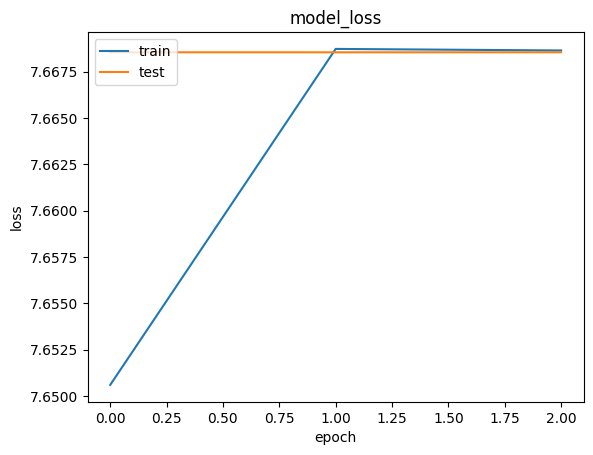

In [15]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

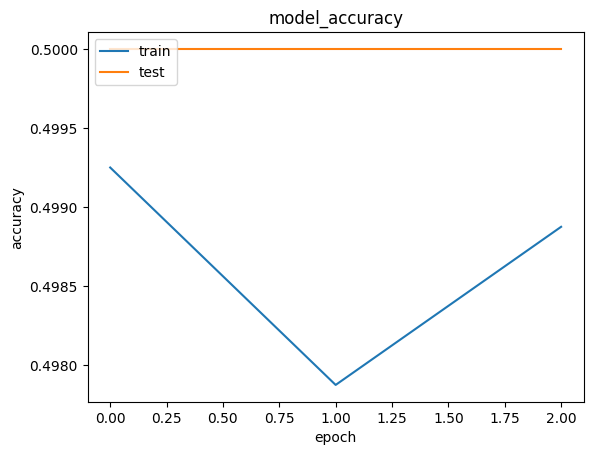

In [16]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()